In [9]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

from tqdm import tqdm

In [2]:
# load & scale
data_path = pathlib.Path().joinpath('data', 'data.csv')
data = pd.read_csv(data_path, index_col='id')
scaled = pd.DataFrame(MinMaxScaler().fit_transform(data), index=data.index, columns=data.columns)

## overview

In [3]:
# check for missing
print(f'Data contain NaN: {data.isna().any().any()}')
print(f'Data contain Inf: {((data == np.inf) | data == -np.inf).any().any()}')

Data contain NaN: False
Data contain Inf: False


In [4]:
# overview feature types
data.dtypes.value_counts()

float64    22
int64       7
dtype: int64

In [5]:
# select int columns
int_columns = data.columns[data.dtypes == int]
data[int_columns]

,f_07,f_08,f_09,f_10,f_11,f_12,f_13
id,,,,,,,
0,2,13,14,5,13,6,6
1,2,3,6,4,6,16,9
2,5,11,5,8,9,3,11
3,6,2,13,8,9,6,4
4,8,7,5,3,1,13,11
...,...,...,...,...,...,...,...
97995,5,7,8,5,7,6,7
97996,3,9,2,5,3,11,12
97997,8,9,10,7,5,4,3


## distributions

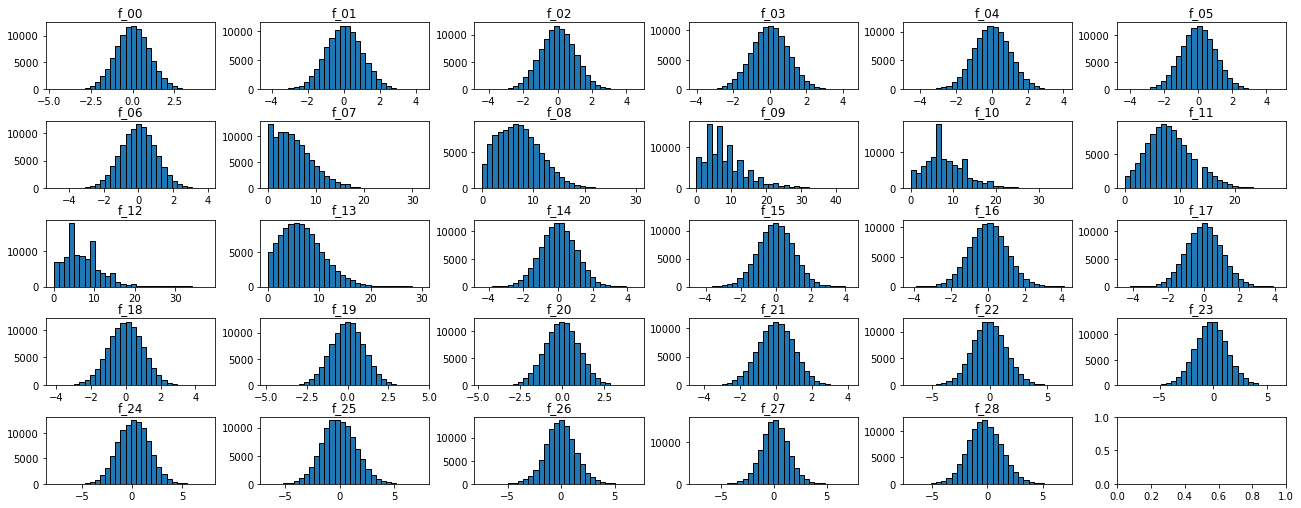

In [69]:
# distribution overview
plot_cols = 6
plot_rows = (data.columns.size // plot_cols) + bool(data.columns.size % plot_cols)

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(18, 7) )
fig.tight_layout()

for n, col in enumerate(data.columns):
    x = n // plot_cols
    y = n % plot_cols
    ax[x, y].set_title(col)
    ax[x, y].hist(data[col], bins=30, edgecolor='black')

plt.show()

## correlations

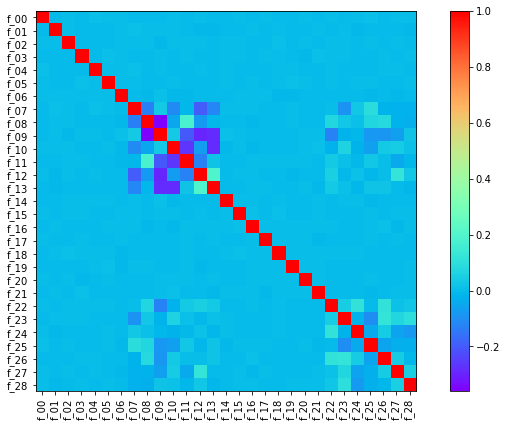

In [91]:
# correlations
fig = plt.figure(figsize=(12, 7))

plt.imshow(data.corr(), cmap='rainbow')
plt.xticks(ticks=range(data.shape[1]), labels=data.columns, rotation=90)
plt.yticks(ticks=range(data.shape[1]), labels=data.columns)
plt.colorbar();

## manually determining number of clusters

In [6]:
def plot_det_score(clust_range, titles=None, *score_args):
    assert titles is None or len(titles) == len(score_args), "Scores and title lengths mismatch"

    fig, ax = plt.subplots(1, len(score_args), figsize=(18, 4))
    fig.suptitle('Different approaches for determining number of clusters')

    for n, sc in enumerate(score_args):
        if titles is not None:
            ax[n].set_title(titles[n])
        ax[n].plot(clust_range, sc)
    plt.show()

### KMeans

k-means clustering: 100%|██████████| 10/10 [15:00<00:00, 90.01s/it]


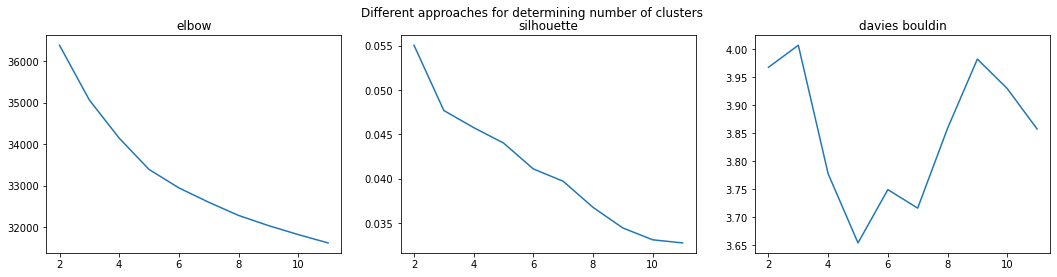

In [7]:
clusters = range(2, 12)
scores = []
silhouette = []
db_score = []

for n in tqdm(clusters, total=len(list(clusters)), desc='k-means clustering'):
    km = KMeans(n_clusters=n, random_state=17).fit(scaled)
    labels = km.predict(scaled)
    # scoring
    scores.append(-km.score(scaled, labels))
    silhouette.append(silhouette_score(scaled, labels))
    db_score.append(davies_bouldin_score(scaled, labels))

plot_det_score(clusters, ['elbow', 'silhouette', 'davies bouldin'], scores, silhouette, db_score)

### GaussianMixture

gaussian clustering: 100%|██████████| 10/10 [14:57<00:00, 89.76s/it]


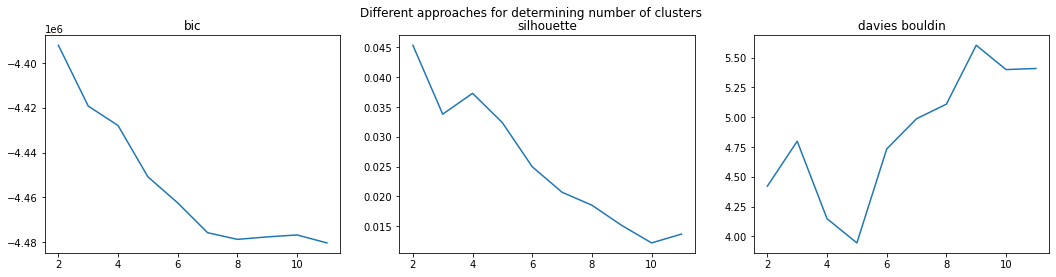

In [10]:
clusters = range(2, 12)
scores = []
silhouette = []
db_score = []

for n in tqdm(clusters, total=len(list(clusters)), desc='gaussian clustering'):
    gmm = GaussianMixture(n_components=n, random_state=17).fit(scaled)
    labels = gmm.predict(scaled)
    # scoring
    scores.append(gmm.bic(scaled))
    silhouette.append(silhouette_score(scaled, labels))
    db_score.append(davies_bouldin_score(scaled, labels))

plot_det_score(clusters, ['bic', 'silhouette', 'davies bouldin'], scores, silhouette, db_score)

## conclusion

Data contain 29 columns without missing values.

There are 7 integer features: from `f_07` to `f_13`, the others are type of float. All float features are normally distributed.<br>
Integer features correlate with last part of features from `f_22` to `f_28`.

In [ ]:
#